In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime as dt, timedelta
import yfinance as yf
import mplfinance as mpf
from shiny import reactive, render
from shiny.express import input, ui

In [9]:
def get_stock_price(ticker, start, end=None):
    ticker = f'{ticker}.T'
    if end is None:
        end = dt.today()

    #print(f'Start_date : {start.date()}\nEnd_date : {end.date()}')

    return_df = yf.download(ticker, start=start, end=end)
    return_df = return_df.stack(future_stack=True).reset_index()

    #print(f'Days : {return_df.shape[0]}')

    return return_df.set_index('Date')

In [37]:
start_date = dt.strptime('2023-07-01', '%Y-%m-%d').date()
start_date_100_days_ago = start_date - timedelta(days=100)
print(start_date_100_days_ago)

2023-03-23


In [ ]:
df = get_stock_price(7974, start_date_100_days_ago, end='2024-10-10')

[*********************100%***********************]  1 of 1 completed


In [24]:
def draw_candle(df, start, end):
    data = df[(df.index.date>start.date()) & (df.index.date<end.date())].drop('Ticker', axis=1)
    
    #ろうそく足
    mpf.plot(data , type='candle', volume=True)

    plt.show()


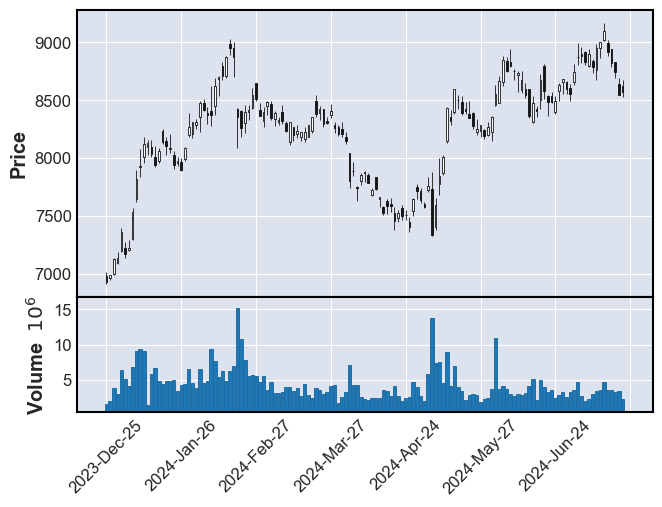

In [26]:
draw_candle(df, dt(2023, 12, 22), dt(2024, 7, 22))